## CS110 Assignment 4 - Genetic Heritage
_Yoav Rabinovich, April 2018_

This assignment calls for analyzing shuffled families of genetic sequences represented as strings, that have undergone mutations between generations. I've interpreted the mutation process as having a set probability for each character to either be deleted, insert a new character in front of it, or mutate into a different character. In part one, we implement a dynamic programming solution to the longest commons subsequence problem that will help us compare sequences later, as we have done in class:

In [1]:
# Reference: "Introduction to Algorithms" 3rd edition by Cormen et al.
# as well as https://www.geeksforgeeks.org/longest-common-substring/

# LCS takes two arrays and returns the length of the longest common subsequence in O(n*m) time
# where n and m are the lengths of the arrays
# I did not include a functionality to print out the subsequence, since in our case I could see little use for such a feature.
def LCS(X, Y):
    #construct a table
    LCS_table = [[0 for x in range(len(Y) + 1)] for y in range(len(X) + 1)]
    #create a variable to return
    result = 0
    #iterate through each pair of items from the two arrays
    for i in range(len(X) + 1):
        for j in range(len(Y) + 1):
            #first line and column are zeros
            if (i == 0 or j == 0):
                LCS_table[i][j] = 0
            #if a pair of charactes is similar, count the subsequence length
            elif (X[i - 1] == Y[j - 1]):
                LCS_table[i][j] = LCS_table[i - 1][j - 1] + 1
                #if the current subsequence is longer than the previous max, replace it
                result = max(result, LCS_table[i][j])
            #otherwise, keep track of the current subsequence length    
            else:
                LCS_table[i][j] = max(LCS_table[i - 1][j], LCS_table[i][j - 1])
    #return the length of the longest common subsequence            
    return result

We now implement a function to graphically display LCS relationships between our gene sequences using the pandas library:

In [142]:
import pandas as pd

# gene_table takes as input an array of an arbitrary amount of sequences of arbitrary lengths,
# compares each pair and displays the length of their longest common substring in O(n^2k^2) time
# where n is the average length of each sequence and k is the number of sequences examined.
def gene_table(genes):
    #set table
    LCS_counter = pd.DataFrame(index=range(len(genes)),columns=range(len(genes)),dtype="float32")
    
    #runs through each pair of sequences
    i_X = -1
    for X in genes:
        i_X += 1
        i_Y = -1
        for Y in genes:
            i_Y += 1
            #handles exception when X=Y
            if i_X != i_Y:
                #computes LCS for each pair
                LCS_counter.iloc[i_X][i_Y] = LCS(X, Y)
            else:
                LCS_counter.iloc[i_X][i_Y] = 0
    #returns table
    return(LCS_counter)

In [143]:
tab = gene_table(['TTCTACGGGGGGAGACCTTTACGAATCACACCGGTCTTCTTTGTTCTAGCCGCTCTTTTTCATCAGTTGCAGCTAGTGCATAATTGCTCACAAACGTATC',
            'TCTACGGGGGGCGTCATTACGGAATCCACACAGGTCGTTATGTTCATCTGTCTCTTTTCACAGTTGCGGCTTGTGCATAATGCTCACGAACGTATC',
            'TCTACGGGGGGCGTCTATTACGTCGCCAACAGGTCGTATGTTCATTGTCATCATTTTCATAGTTGCGGCCTGTGCGTGCTTACGAACGTATTCC',
            'TCCTAACGGGTAGTGTCATACGGAATCGACACGAGGTCGTATCTTCAATTGTCTCTTCACAGTTGCGGCTGTCCATAAACGCGTCCCGAACGTTATG',
            'TATCAGTAGGGCATACTTGTACGACATTCCCCGGATAGCCACTTTTTTCCTACCCGTCTCTTTTTCTGACCCGTTCCAGCTGATAAGTCTGATGACTC',
            'TAATCTATAGCATACTTTACGAACTACCCCGGTCCACGTTTTTCCTCGTCTTCTTTCGCTCGATAGCCATGGTAACTTCTACAAAGTTC',
            'TATCATAGGGCATACTTTTACGAACTCCCCGGTGCACTTTTTTCCTACCGCTCTTTTTCGACTCGTTGCAGCCATGATAACTGCTACAAACTTC'])
print(tab)

      0     1     2     3     4     5     6
0   0.0  82.0  73.0  72.0  72.0  70.0  80.0
1  82.0   0.0  83.0  81.0  67.0  65.0  70.0
2  73.0  83.0   0.0  73.0  62.0  61.0  67.0
3  72.0  81.0  73.0   0.0  62.0  60.0  63.0
4  72.0  67.0  62.0  62.0   0.0  71.0  82.0
5  70.0  65.0  61.0  60.0  71.0   0.0  79.0
6  80.0  70.0  67.0  63.0  82.0  79.0   0.0


Let's construct a weighed edge graph to visualize the relationships better, treating our table as an adjacency matrix and using the networkx library:

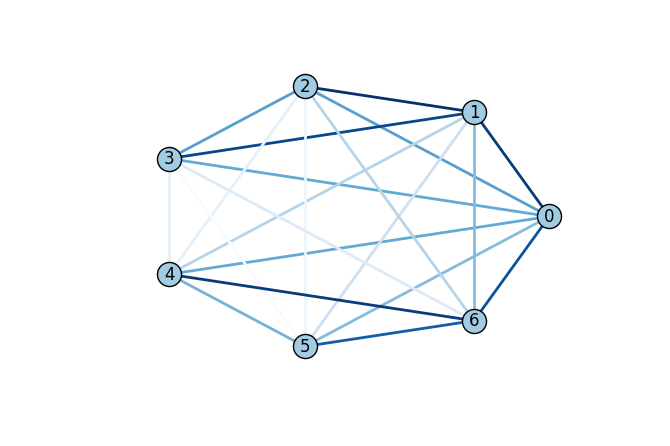

In [192]:
import matplotlib.pyplot as plt
import networkx as nx

#create graph from the pandas adjacency table
G = nx.from_pandas_adjacency(tab)
#set color intensity of edges
colors = [tab.values[e[0]][e[1]] for e in G.edges]
#draw graph
nx.draw_circular(G, node_color='#A0CBE2',width=2,edge_color=colors,
                 edge_cmap=plt.cm.Blues,with_labels=True)


plt.show()

_Figure 2. graph of sequences weighted by LCS length gives rise to a binary tree structure_

We can see a suggested hierarchy forming. The strongest similarity is between sequence 0 and sequences 1 and 6. They then each have two strongly connected sequences. The farthest distances are between the sequences strongly connected to 1 and those strongly connected to 6. This structure makes sense, since each sequence has two children, which are removed from it with fewer mutative steps than any other sequence. Making the assumption that the most closely connected sequences are parent and child is not foolproof: It could be that two children end up more similar to each other than to their children, or that a grandchild ends up more similar to it's grandparent than it's parent. However, with _n_ mutation opportunites in a sequence of length _n_, and with sequences with _n=~100_, the likelihood for this coincidence is extremely small. In conclusion, it would be a safe assumption that the two sequences with the longest LCS with a given sequence apart from its parent are its children.

We would need to identify a global parent to have a stopping condition for the recursion. We can examine another property of this system: higher rank sequences tend to have larger average connection strength with the entire graph. This is because with each generation, the children are very likely as discussed above to diverge from each other, while still resembling their parental line. The original sequence is very likely to be the most connected since it contains the maximum amount of inheritable information. All we need to do then is:

1. Rank sequences by average connectedness
2. Separate the sequences into hierarchy levels (level=floor(log(i+1)) for an index _i_ in a binary tree).
3. Compare each sequence from a higher hierarchy to the sequences in the lower hierarchy, and choose the two strongest connections.
4. Mark those sequences as its children, and take them out of the pool of possible children.
5. repeat 3-4 until all connections were made between the two hierarcies
6. repeat 3-5 for a pair of hierarcies one degree deeper down the tree.

**Complexity analysis:** 

Step by step:
1. Our hierarcy function would run once for each of _k_ examined sequences, and run a python's default _O(nlog(n)) sort on each for a total complexity of _O(knlog(n))_
2. Separation would entail a single constant calculation for each sequence in _O(k)_.
3. and onwards: a comparison is a constant time operation, and we could've traveresed the entire length _k_ to look at each pair of sequences for a complexity of _O(k^2)_. However, we only have to examine the subsequent level, and we only need to look at sequences we didn't already list as children. The calculation got a bit too complicated for me so I solved the problem numerically: I plotted known amounts of comparisons for given amounts of _k_, and calculated best fit lines for linear, polynomial and exponential complexity, comparing their residuals. I find that even considering all possible simplification, the complexity still scales with _O(k^2)_.

This function would require us to run first our gene_table() function. As noted in the code above, the total complexity for that function is _O(n^2k^2)_. That is because it examines each pair of amount _k_ of sequences examined, and for each runs our LCS() function which compares every pair of average amount _n_ of items a pair of sequences. Since half the table is redundant, we can cut that by half, but simplification would round it up again.

This gives us a total complexity of _O(n^2k^2)+O(knlog(n))+O(k)+O(k^2)_, which can be simplified simply into _O(k^2n^2)_, meaning it's the creation of the LCS table that dominates the computing time.

![title](complexity.PNG)

_Figure 2. Numerical analysis of number of comparisons required for amount of sequences k clearly shows a polynomial complexity._

Now is a convenient time to turn to approximating the probability of insertion, deletion or mutation for each item in a replicated sequence. Since we have an approach to pairing parent sequences with their children, we can easily compare only true parent-child pairs. To compute these probability, we observe that any change in replication would not appear in the LCS between the parent and the child. Therefore, we could go through the LCS for each parent-child pair, and only examine items that exist in one of the arrays and not in the LCS. Once we have identified such an item, we can categorize it into either a deletion or an insertion:

|         |In Parent|In Child|
|---------|---------|--------|
|Insertion|No       |Yes     |
|Deletion |Yes      |No      |

A mutation is a bit more complicated. It manifests as both an insertion and a deletion, and in a special case it cannot be distinguished at all from a combination of the two: a scenario where a character inserts and the next is deleted is similar in all aspects to a scenario where a character is dormant and the next mutates. However, observing the relative rarity of changes in replication, we can make a simplifying assumption that and instance where a character is missing and a new one appears in the same spot is categorized as a mutation, since it's much more likely than the alternate explanation, requiring to specific changes in a row.

Now that we have a list of approximated changes per replication, we normalize each list into a set of probability that sums to 1 by dividing the instances by the number of items in the sequence, and marking the compliment as the probability of no change. The last step is averaging the deletion, insertion and mutation probabilities across all replications, leaving us with our best approximation of change probabilities.

Disclaimer: I have collaborated with my classmate Michelle Hackl when writing some of the code for this assignment.